In [12]:
import pandas as pd
from keras.layers import LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
def date_parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

In [4]:
series = pd.read_csv("shampoo_sales.csv", header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=date_parser)
series.head()

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Shampoo_Sales, dtype: float64

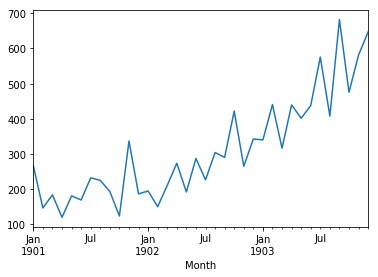

In [5]:
series.plot()
plt.show()

In [6]:
X = series.values
train,test = X[0:-12], X[-12:]  # use the last year as testing data
train

array([ 266. ,  145.9,  183.1,  119.3,  180.3,  168.5,  231.8,  224.5,
        192.8,  122.9,  336.5,  185.9,  194.3,  149.5,  210.1,  273.3,
        191.4,  287. ,  226. ,  303.6,  289.9,  421.6,  264.5,  342.3])

RMSE: 136.761


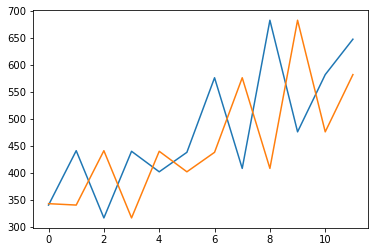

In [16]:
# Univariate time series
## Each time step will be walked one at a time - Walk Forward Validation
## For TEST DATA time t, t+1 will be predicted, then the ACTUAL t+1 value will be added to history data to predict t+2
## This is a baseline method, since you simply use the previous 1 step data as the prediction

history = [h for h in train]  # convert numpy array to normal array
prediction = []
for i in range(len(test)):
    prediction.append(history[-1])
    history.append(test[i])
    
# RMSE to show perdiction accuracy
rmse = np.sqrt(mean_squared_error(test, prediction))
print('RMSE: %.3f' % rmse)

plt.plot(test)
plt.plot(prediction)
plt.show()

In [17]:
# LSTM
# Step 1 - Data Preprocessing
## transform the time series into supervised problem
## make time series stationary
## make observations in scale

In [23]:
## transform to supervised data - shift training data down as testing data
from pandas import datetime, DataFrame, concat

def ts2supervised(training_data, lag=1):
    training_df = DataFrame(training_data)
    testing_df = [training_df.shift(k) for k in range(1, lag+1)]  # shift DOWM lag steps
    testing_df.append(training_df)
    df = concat(testing_df, axis=1)  # first argument must be an iterable
    df.fillna(0, inplace=True)  # In this case, 0 tells LSTM it's the start point, since sales data has no 0 originally
    return df

supervised_data = ts2supervised(X, 1)
supervised_data.columns = ['Testing', 'Training']
supervised_data.head()

,Testing,Training
0,0.0,266.0
1,266.0,145.9
2,145.9,183.1
3,183.1,119.3
4,119.3,180.3
